In [1]:
!pip install -q torch torchvision timm scikit-learn albumentations pandas matplotlib tqdm


In [2]:
from google.colab import files
files.upload()   # ⬅️ choose your kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"binhdiep","key":"8667e2391290a7a95947eeb13dfa30a1"}'}

In [3]:
!mv "kaggle (17).json" kaggle.json


mv: cannot stat 'kaggle (17).json': No such file or directory


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets list -s ham10000


ref                                                          title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
kmader/skin-cancer-mnist-ham10000                            Skin Cancer MNIST: HAM10000                       5582914511  2018-09-20 20:36:13.037000         226255       2168  0.7058824        
surajghuwalewala/ham1000-segmentation-and-classification     Skin cancer: HAM10000                             2781385274  2021-05-27 09:08:46.813000          16639        127  0.9411765        
tschandl/ham10000-lesion-segmentations                       HAM10000 Lesion Segmentations                       10766207  2020-07-02 21:20:22.710000           2037         33  0.875            
nightfury007/ham10000-isi

In [8]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:11<00:00, 498MB/s]
100% 5.20G/5.20G [00:11<00:00, 493MB/s]


In [9]:
!mkdir -p /content/HAM10000_images
!cp /content/HAM10000_images_part_1/* /content/HAM10000_images/
!cp /content/HAM10000_images_part_2/* /content/HAM10000_images/


In [10]:
import torch, timm, numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pandas as pd, os

# ==== CONFIG ====
CSV_FILE = "/content/HAM10000_metadata.csv"
IMG_DIR = "/content/HAM10000_images"
OUT_DIR = "/content/outputs"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 3e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(OUT_DIR, exist_ok=True)
print("Using device:", device)

# ==== LOAD DATA ====
df = pd.read_csv(CSV_FILE)


Using device: cuda


In [11]:
CSV_FILE = "/content/HAM10000_metadata.csv"
IMG_DIR = "/content/HAM10000_images"
OUT_DIR = "/content/outputs"

import os
os.makedirs(OUT_DIR, exist_ok=True)
print("✅ Paths ready")


✅ Paths ready


In [12]:
import torch, timm, numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv(CSV_FILE)
print("✅ Metadata shape:", df.shape)
print("✅ Sample columns:", df.columns.tolist())

import os
print("✅ Total images:", len(os.listdir(IMG_DIR)))
df.head()


✅ Metadata shape: (10015, 7)
✅ Sample columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']
✅ Total images: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [17]:
# ==== CONFIG ====
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 3e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ==== PREPARE DATA ====
df['label_str'] = df['dx']
classes = sorted(df['label_str'].unique())
df['label'] = df['label_str'].map({c:i for i,c in enumerate(classes)})

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),  # ✅ Fixed for v2.x
            A.HorizontalFlip(),
            A.VerticalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),  # ✅ This stays same
            A.Normalize(),
            ToTensorV2(),
        ])

class SkinDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, row['image_id'] + '.jpg')).convert('RGB'))
        if self.transform: img = self.transform(image=img)['image']
        label = int(row['label'])
        return img, label

train_loader = DataLoader(SkinDataset(train_df, IMG_DIR, get_transforms('train')), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SkinDataset(val_df, IMG_DIR, get_transforms('val')), batch_size=BATCH_SIZE)

# ==== MODEL ====
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

# ==== TRAINING ====
best_acc = 0
train_losses, val_accuracies, train_accs = [], [], []  # added train_accs list

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # === Compute Training Accuracy ===
    model.eval()
    train_preds, train_true = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_true.extend(labels.cpu().numpy())
    train_acc = accuracy_score(train_true, train_preds)

    # === Validation ===
    preds, true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(outputs.argmax(1).cpu().numpy())
            true.extend(labels.cpu().numpy())
    val_acc = accuracy_score(true, preds)

    # === Log and Save ===
    print(f"Epoch {epoch+1} | Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    train_losses.append(running_loss / len(train_loader))
    val_accuracies.append(val_acc)
    train_accs.append(train_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_model.pth"))
        print("✅ Saved best model")

# === Save Final Model ===
torch.save(model.state_dict(), os.path.join(OUT_DIR, "final_model.pth"))
print("✅ Final model saved manually!")
print("Training Complete! Best Val Accuracy:", best_acc)


Using device: cuda


Epoch 1/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 1 | Train Loss: 0.6562 | Train Acc: 0.8444 | Val Acc: 0.8263
✅ Saved best model


Epoch 2/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 2 | Train Loss: 0.4163 | Train Acc: 0.8740 | Val Acc: 0.8486
✅ Saved best model


Epoch 3/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 3 | Train Loss: 0.3168 | Train Acc: 0.9145 | Val Acc: 0.8744
✅ Saved best model


Epoch 4/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 4 | Train Loss: 0.2360 | Train Acc: 0.9298 | Val Acc: 0.8650


Epoch 5/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 5 | Train Loss: 0.1922 | Train Acc: 0.9584 | Val Acc: 0.8991
✅ Saved best model


Epoch 6/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 6 | Train Loss: 0.1459 | Train Acc: 0.9619 | Val Acc: 0.8850


Epoch 7/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 7 | Train Loss: 0.1261 | Train Acc: 0.9440 | Val Acc: 0.8791


Epoch 8/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 8 | Train Loss: 0.1139 | Train Acc: 0.9796 | Val Acc: 0.8932


Epoch 9/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 9 | Train Loss: 0.0812 | Train Acc: 0.9822 | Val Acc: 0.8885


Epoch 10/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 10 | Train Loss: 0.0782 | Train Acc: 0.9758 | Val Acc: 0.8932


Epoch 11/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 11 | Train Loss: 0.0724 | Train Acc: 0.9798 | Val Acc: 0.8744


Epoch 12/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 12 | Train Loss: 0.0655 | Train Acc: 0.9834 | Val Acc: 0.8920


Epoch 13/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 13 | Train Loss: 0.0625 | Train Acc: 0.9811 | Val Acc: 0.8826


Epoch 14/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 14 | Train Loss: 0.0447 | Train Acc: 0.9866 | Val Acc: 0.8850


Epoch 15/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 15 | Train Loss: 0.0570 | Train Acc: 0.9914 | Val Acc: 0.8955


Epoch 16/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 16 | Train Loss: 0.0308 | Train Acc: 0.9856 | Val Acc: 0.8920


Epoch 17/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 17 | Train Loss: 0.0475 | Train Acc: 0.9841 | Val Acc: 0.8873


Epoch 18/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 18 | Train Loss: 0.0371 | Train Acc: 0.9859 | Val Acc: 0.8885


Epoch 19/20: 100%|██████████| 240/240 [01:43<00:00,  2.31it/s]


Epoch 19 | Train Loss: 0.0364 | Train Acc: 0.9905 | Val Acc: 0.8991


Epoch 20/20: 100%|██████████| 240/240 [01:43<00:00,  2.32it/s]


Epoch 20 | Train Loss: 0.0394 | Train Acc: 0.9935 | Val Acc: 0.8979
✅ Final model saved manually!
Training Complete! Best Val Accuracy: 0.8990610328638498


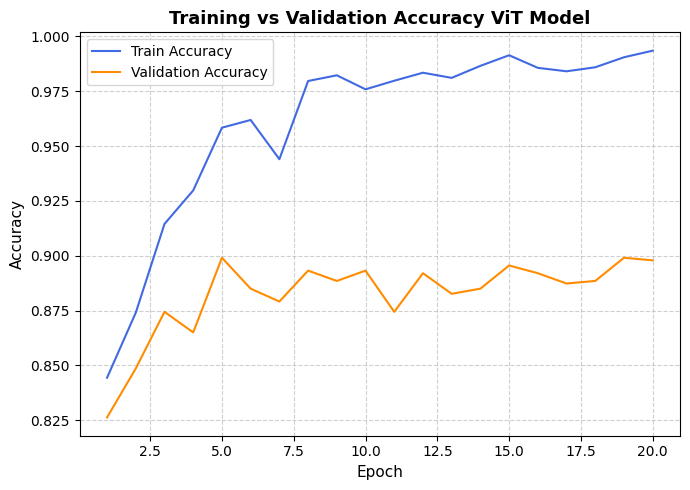

In [27]:
# === Validation Curve (Training vs Validation Accuracy) ===
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracies) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_accs, label='Train Accuracy', color='royalblue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='darkorange')

plt.title('Training vs Validation Accuracy ViT Model', fontsize=13, weight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=len(classes)).to(device)
model.load_state_dict(torch.load("/content/outputs/best_model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully for evaluation.")


✅ Model loaded successfully for evaluation.


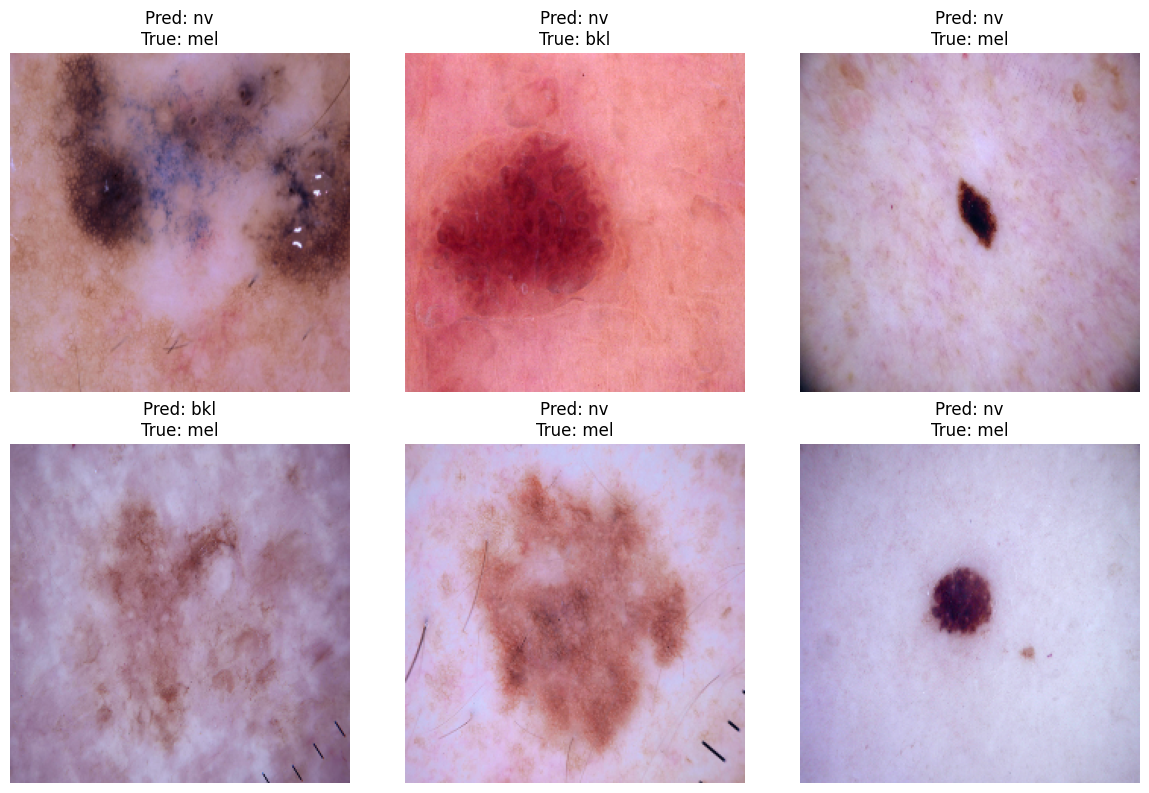

In [21]:
import matplotlib.pyplot as plt

# ==== LOAD BEST MODEL ====
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pth"), map_location=device))
model.eval()

# ==== PREDICT ON VALIDATION SET ====
misclassified = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].cpu().item(), labels[i].cpu().item()))

# ==== SHOW SOME MISCLASSIFIED IMAGES ====
def imshow(img, title):
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display first 6 misclassified samples
plt.figure(figsize=(12, 8))
for i, (img, pred, true) in enumerate(misclassified[:6]):
    plt.subplot(2, 3, i + 1)
    imshow(img, f"Pred: {classes[pred]}\nTrue: {classes[true]}")
plt.tight_layout()
plt.show()


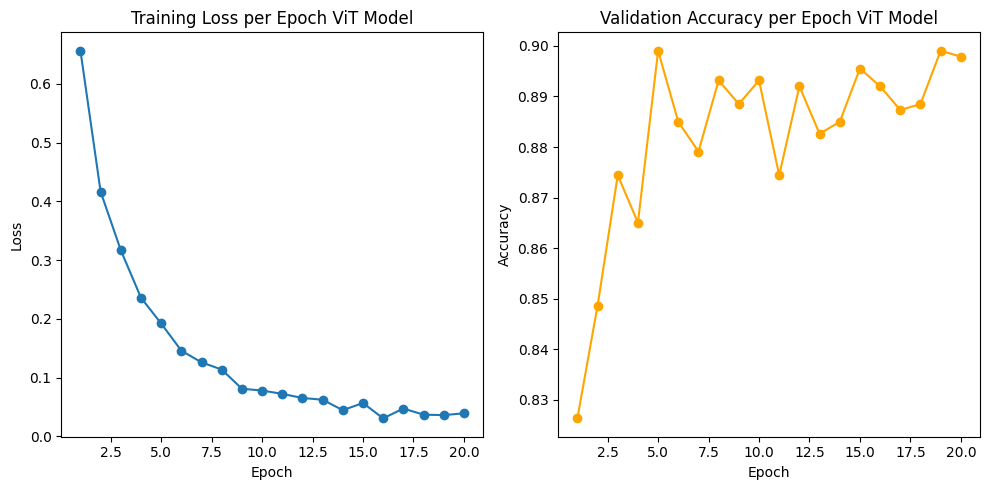

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title("Training Loss per Epoch ViT Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), val_accuracies, marker='o', color='orange')
plt.title("Validation Accuracy per Epoch ViT Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


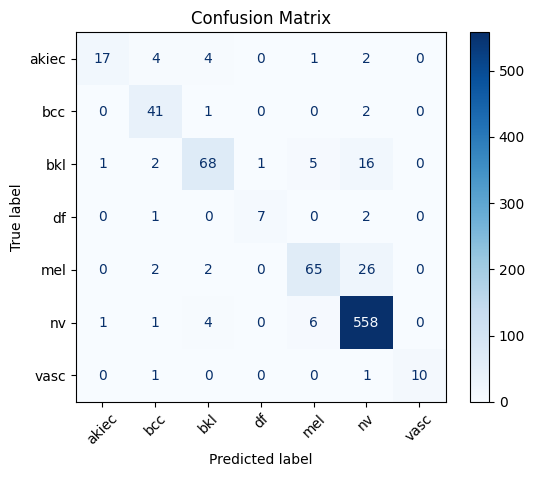


Classification Report:

              precision    recall  f1-score   support

       akiec       0.89      0.61      0.72        28
         bcc       0.79      0.93      0.85        44
         bkl       0.86      0.73      0.79        93
          df       0.88      0.70      0.78        10
         mel       0.84      0.68      0.76        95
          nv       0.92      0.98      0.95       570
        vasc       1.00      0.83      0.91        12

    accuracy                           0.90       852
   macro avg       0.88      0.78      0.82       852
weighted avg       0.90      0.90      0.89       852



In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


✅ Loaded best model from /content/outputs/best_model.pth

📊 Training Accuracy: 0.9595


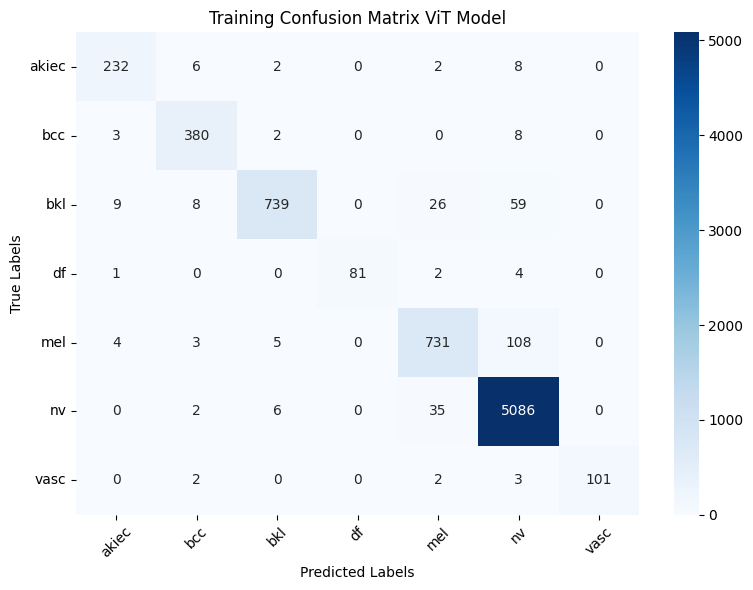

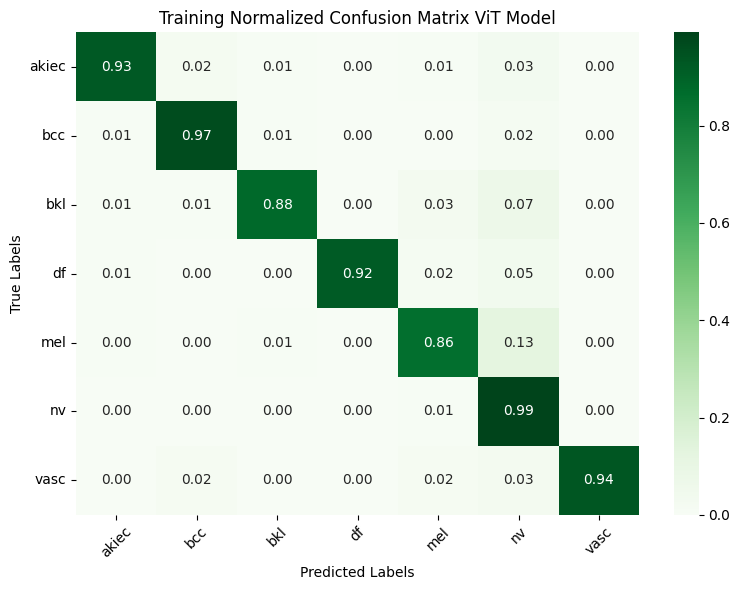


🧾 Training Classification Report:
              precision    recall  f1-score   support

       akiec       0.93      0.93      0.93       250
         bcc       0.95      0.97      0.96       393
         bkl       0.98      0.88      0.93       841
          df       1.00      0.92      0.96        88
         mel       0.92      0.86      0.89       851
          nv       0.96      0.99      0.98      5129
        vasc       1.00      0.94      0.97       108

    accuracy                           0.96      7660
   macro avg       0.96      0.93      0.94      7660
weighted avg       0.96      0.96      0.96      7660


📊 Validation Accuracy: 0.8991


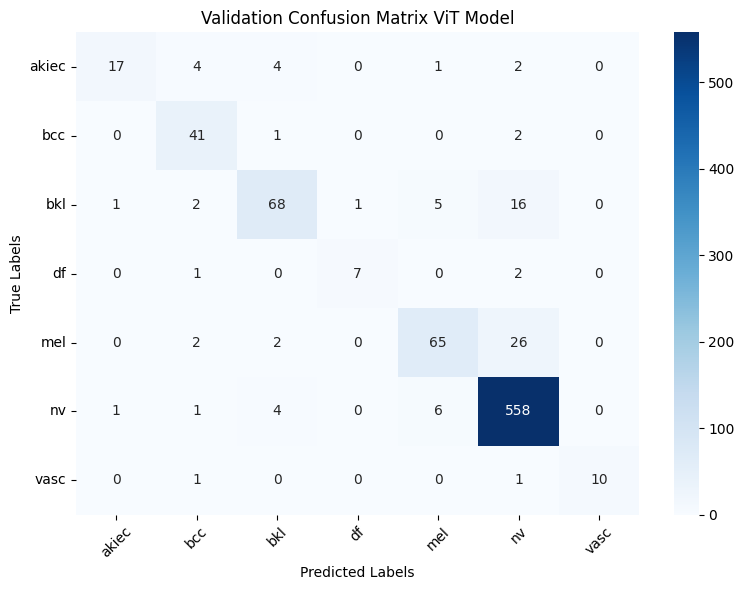

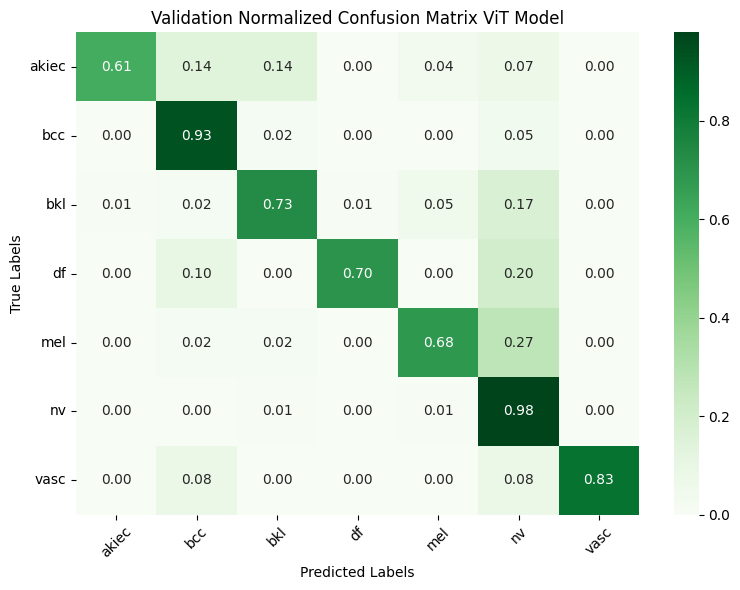


🧾 Validation Classification Report:
              precision    recall  f1-score   support

       akiec       0.89      0.61      0.72        28
         bcc       0.79      0.93      0.85        44
         bkl       0.86      0.73      0.79        93
          df       0.88      0.70      0.78        10
         mel       0.84      0.68      0.76        95
          nv       0.92      0.98      0.95       570
        vasc       1.00      0.83      0.91        12

    accuracy                           0.90       852
   macro avg       0.88      0.78      0.82       852
weighted avg       0.90      0.90      0.89       852


📊 Test Accuracy: 0.8909


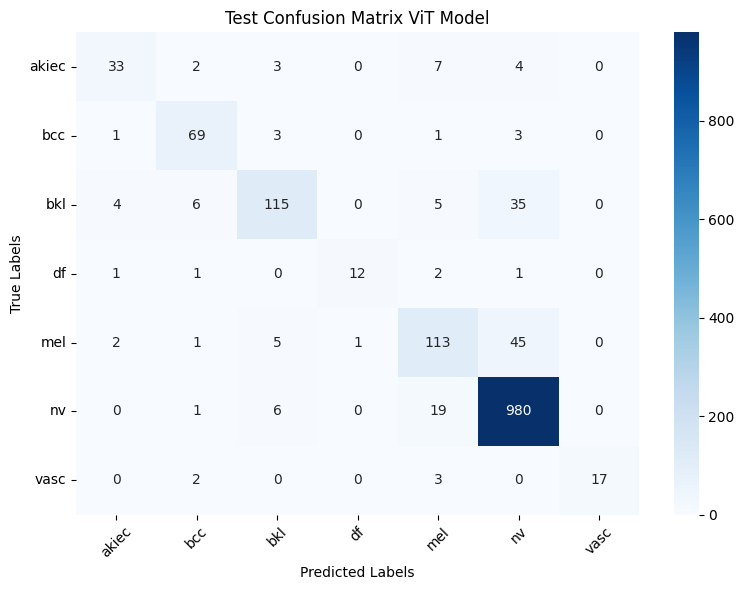

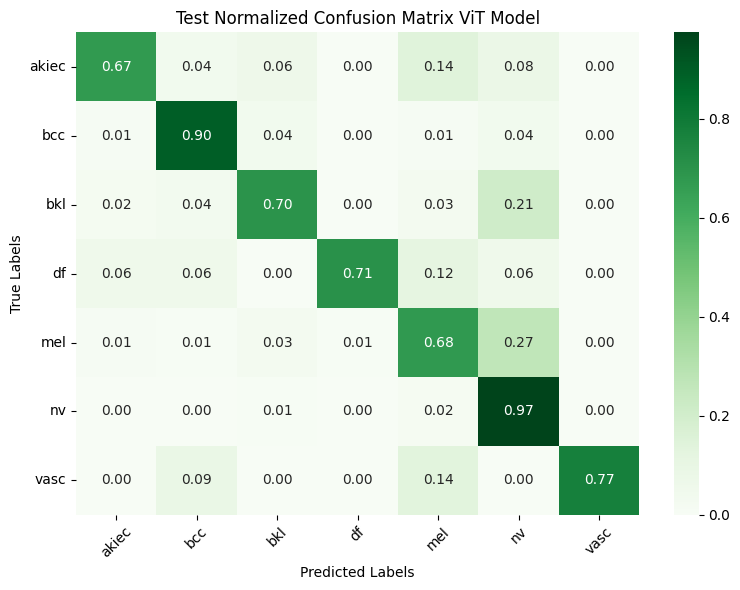


🧾 Test Classification Report:
              precision    recall  f1-score   support

       akiec       0.80      0.67      0.73        49
         bcc       0.84      0.90      0.87        77
         bkl       0.87      0.70      0.77       165
          df       0.92      0.71      0.80        17
         mel       0.75      0.68      0.71       167
          nv       0.92      0.97      0.95      1006
        vasc       1.00      0.77      0.87        22

    accuracy                           0.89      1503
   macro avg       0.87      0.77      0.82      1503
weighted avg       0.89      0.89      0.89      1503



In [30]:
# ==== EVALUATION FOR TRAIN, VAL, AND TEST SETS ====
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Load the best model ===
best_model_path = os.path.join(OUT_DIR, "best_model.pth")
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"✅ Loaded best model from {best_model_path}")
else:
    print("⚠️ Best model not found, using current weights")

# === Helper Function for Confusion Matrix & Report ===
def evaluate_model(loader, split_name="Validation"):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # === Accuracy ===
    acc = accuracy_score(y_true, y_pred)
    print(f"\n📊 {split_name} Accuracy: {acc:.4f}")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{split_name} Confusion Matrix ViT Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # === Normalized Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{split_name} Normalized Confusion Matrix ViT Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # === Classification Report ===
    print(f"\n🧾 {split_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

# === Evaluate on all splits ===
evaluate_model(train_loader, "Training")
evaluate_model(val_loader, "Validation")
evaluate_model(DataLoader(SkinDataset(test_df, IMG_DIR, get_transforms('val')), batch_size=BATCH_SIZE), "Test")